In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [4]:
# Fetch dataset from UCI ML Repository
heart_disease = fetch_ucirepo(id=45)

# Extract features and targets
X = heart_disease.data.features
y = heart_disease.data.targets

# Combine into single DataFrame
data = pd.concat([X, y], axis=1)

# Show data size
print(data.shape)

# Show first part of data
data.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


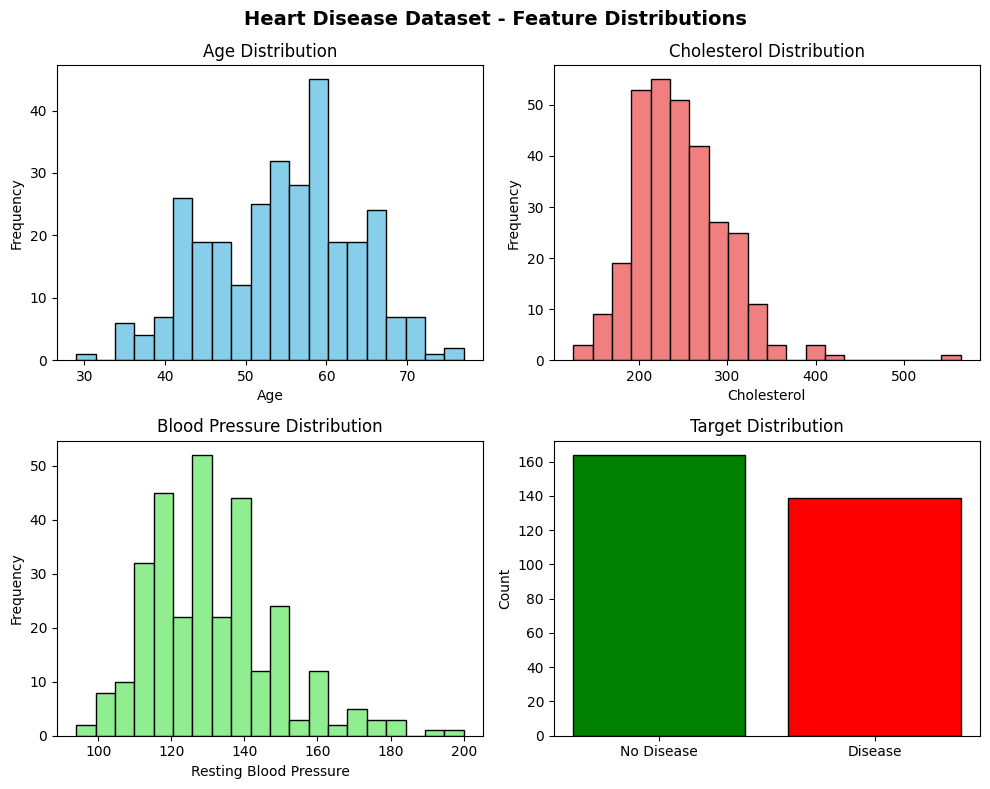

In [5]:
# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Heart Disease Dataset - Feature Distributions', fontsize=14, fontweight='bold')

# Select a few key features to visualize
axes[0, 0].hist(data['age'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution')

axes[0, 1].hist(data['chol'], bins=20, color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Cholesterol')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Cholesterol Distribution')

axes[1, 0].hist(data['trestbps'], bins=20, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Resting Blood Pressure')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Blood Pressure Distribution')

axes[1, 1].bar(['No Disease', 'Disease'], [sum(data['num']==0), sum(data['num']>0)], 
               color=['green', 'red'], edgecolor='black')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Target Distribution')

plt.tight_layout()
plt.show()

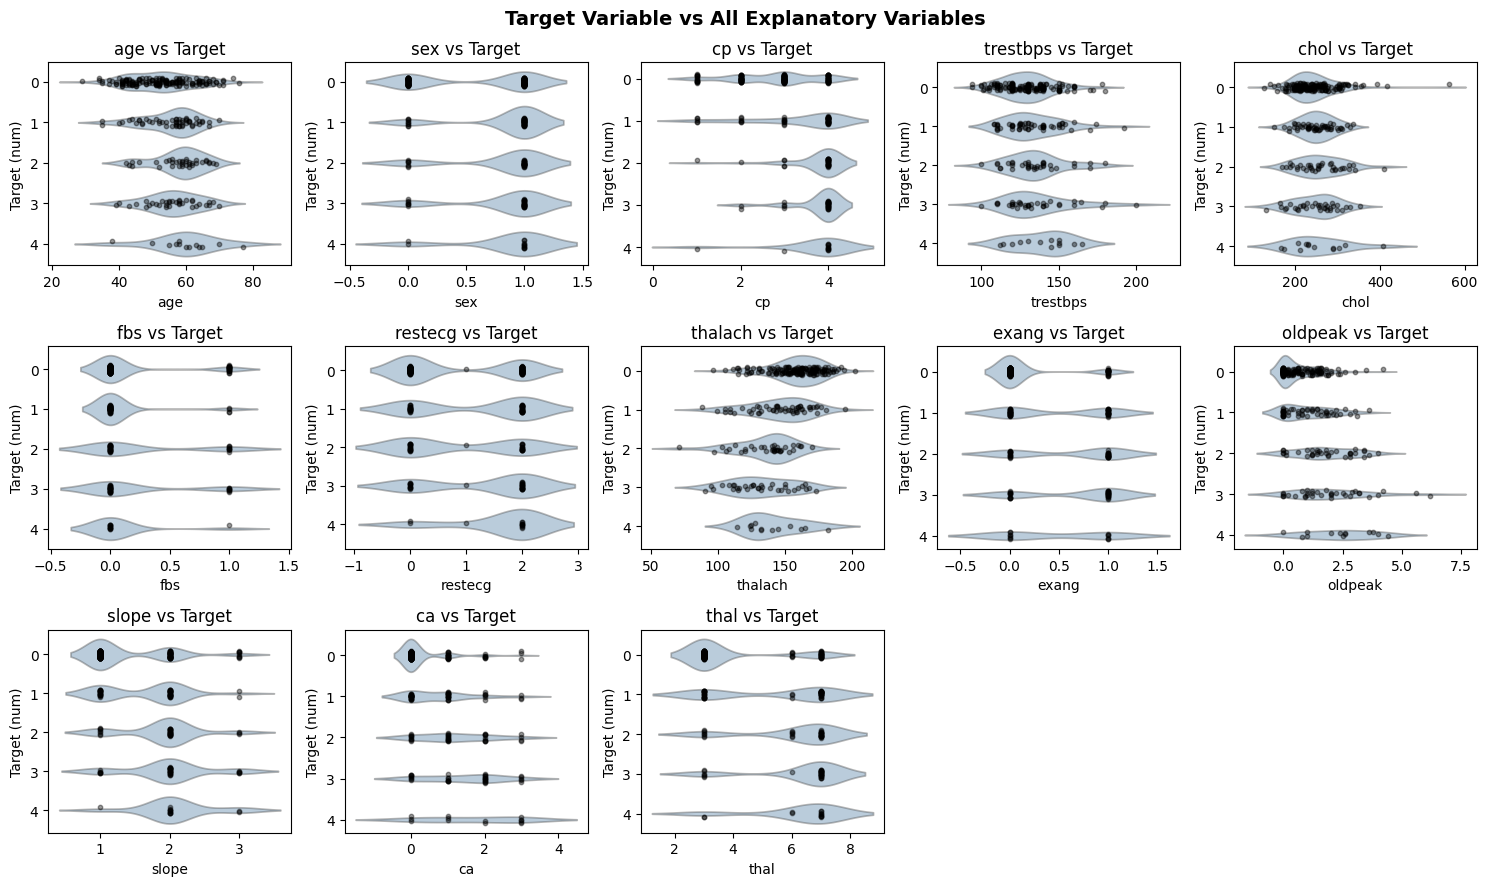

In [6]:
# Plot correlations between target and all explanatory variables
# Get feature names (all columns except target)
feature_cols = [col for col in data.columns if col != 'num']
n_features = len(feature_cols)

# Create subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for idx, feature in enumerate(feature_cols):
    ax = axes[idx]

    # Violin plot without internal box/lines
    sns.violinplot(
        data=data,
        y='num',
        x=feature,
        ax=ax,
        orient='h',
        color='steelblue',
        alpha=0.4,
        inner=None  # <â€” removes median & quantile boxes
    )

    # Overlay raw data with vertical jitter for density visibility
    jittered_y = data['num'] + np.random.uniform(-0.1, 0.1, size=len(data))
    ax.scatter(data[feature], jittered_y, color='black', alpha=0.4, s=10)

    ax.set_ylabel('Target (num)')
    ax.set_xlabel(feature)
    ax.set_title(f'{feature} vs Target')

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

fig.suptitle('Target Variable vs All Explanatory Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [7]:
# Separate features and target
X = data.drop("num", axis=1)
y = data["num"].apply(lambda x: 0 if x == 0 else 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Training samples: 242, Test samples: 61
Number of features: 13
Target distribution: {0: 164, 1: 139}


Test Accuracy: 0.883
Training Accuracy: 0.844


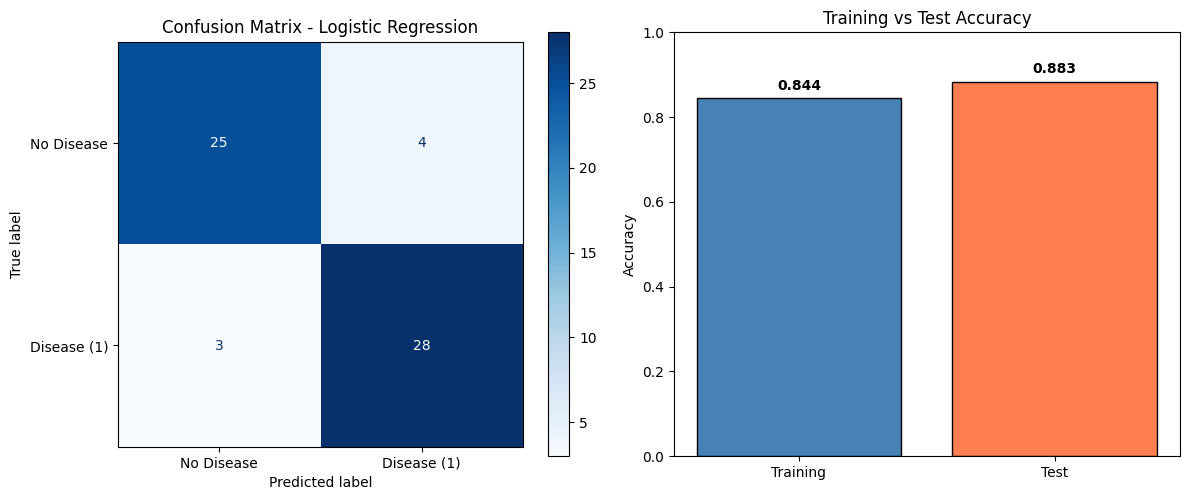

In [8]:
# Initialize and train logistic regression
model = LogisticRegression(max_iter=1000)

# Remove rows with NaNs
X_train_no_nan = X_train.dropna()
y_train_no_nan = y_train[X_train_no_nan.index]
X_test_no_nan = X_test.dropna()
y_test_no_nan = y_test[X_test_no_nan.index]

# Scale features for better convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_nan)
X_test_scaled = scaler.transform(X_test_no_nan)

model.fit(X_train_scaled, y_train_no_nan)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate accuracy
acc = accuracy_score(y_test_no_nan, y_pred)
print(f"Test Accuracy: {acc:.3f}")

# Also check training accuracy
y_train_pred = model.predict(X_train_scaled)
train_acc = accuracy_score(y_train_no_nan, y_train_pred)
print(f"Training Accuracy: {train_acc:.3f}")

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
cm = confusion_matrix(y_test_no_nan, y_pred)
# Get unique labels from the target variable
unique_labels = sorted(y_test_no_nan.unique())
# Create display labels: 0 = No Disease, >0 = Disease
display_labels = ['No Disease' if label == 0 else f'Disease ({label})' for label in unique_labels]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - Logistic Regression')

# Accuracy comparison
accuracies = [train_acc, acc]
labels = ['Training', 'Test']
colors = ['steelblue', 'coral']
axes[1].bar(labels, accuracies, color=colors, edgecolor='black')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([0, 1])
axes[1].set_title('Training vs Test Accuracy')
for i, v in enumerate(accuracies):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
plt.close('all')  # Close all figures to prevent empty figure warnings
# end snippet train_evaluate



Decision Tree Training Accuracy: 1.000
Decision Tree Test Accuracy: 0.738

Logistic Regression Training Accuracy: 0.844
Logistic Regression Test Accuracy: 0.883


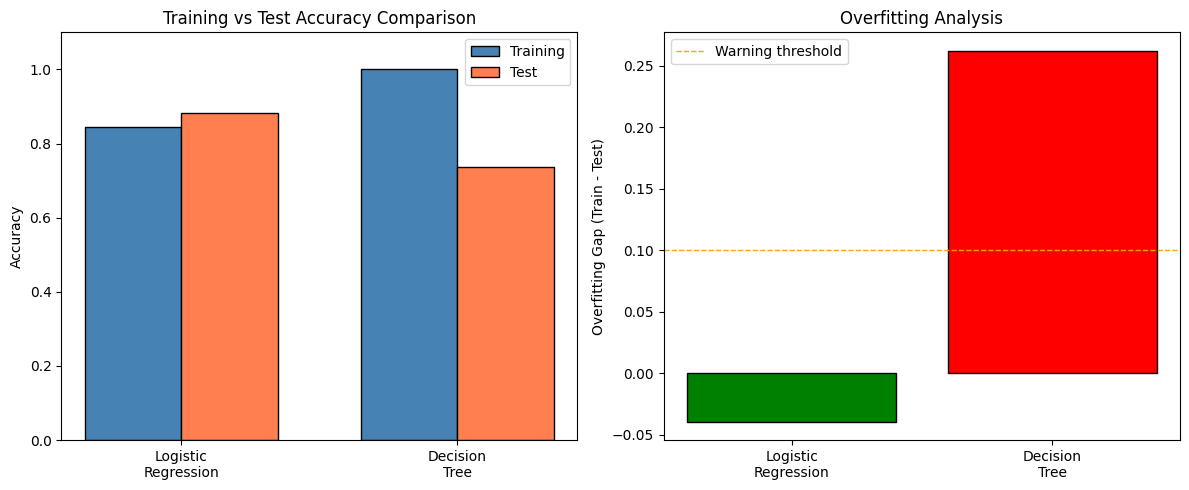

In [9]:
# Train a Decision Tree (no depth limit - can overfit)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate on both training and test sets
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)

dt_train_acc = accuracy_score(y_train, dt_train_pred)
dt_test_acc = accuracy_score(y_test, dt_test_pred)

print(f"Decision Tree Training Accuracy: {dt_train_acc:.3f}")
print(f"Decision Tree Test Accuracy: {dt_test_acc:.3f}")
print(f"\nLogistic Regression Training Accuracy: {train_acc:.3f}")
print(f"Logistic Regression Test Accuracy: {acc:.3f}")

# Visualize the overfitting comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Model comparison
models = ['Logistic\nRegression', 'Decision\nTree']
train_accs = [train_acc, dt_train_acc]
test_accs = [acc, dt_test_acc]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, train_accs, width, label='Training', color='steelblue', edgecolor='black')
axes[0].bar(x + width/2, test_accs, width, label='Test', color='coral', edgecolor='black')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training vs Test Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].set_ylim([0, 1.1])

# Overfitting gap
gaps = [train_acc - acc, dt_train_acc - dt_test_acc]
colors_gap = ['green' if g < 0.1 else 'orange' if g < 0.2 else 'red' for g in gaps]
axes[1].bar(models, gaps, color=colors_gap, edgecolor='black')
axes[1].set_ylabel('Overfitting Gap (Train - Test)')
axes[1].set_title('Overfitting Analysis')
axes[1].axhline(y=0.1, color='orange', linestyle='--', linewidth=1, label='Warning threshold')
axes[1].legend()

plt.tight_layout()
plt.show()
# end snippet overfitting_example


Cross-validation scores: [0.85       0.86666667 0.77966102 0.83050847 0.79661017]
Mean accuracy: 0.825 (+/- 0.065)


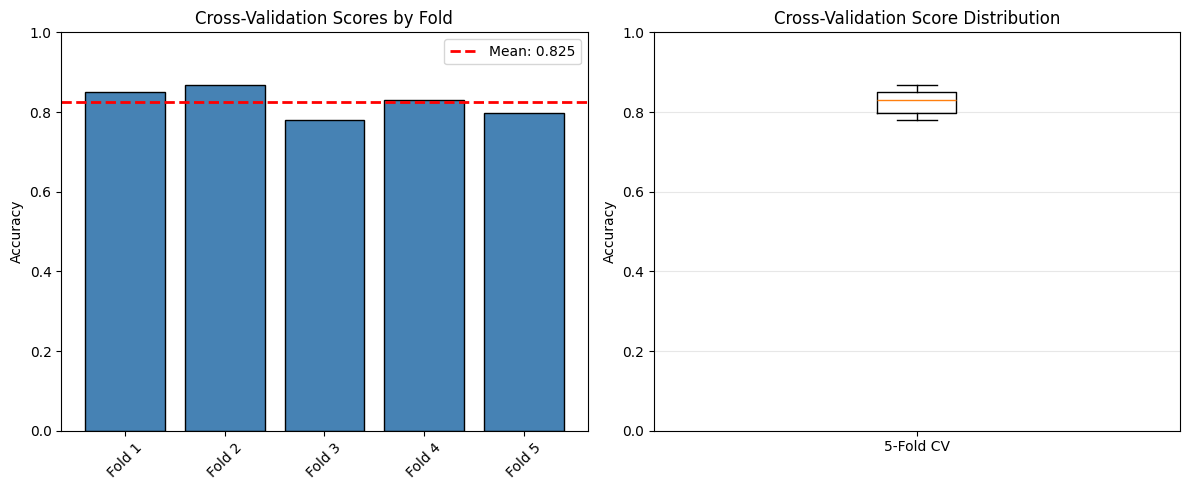

In [10]:
# Remove rows with NaNs for cross-validation
X_clean = X.dropna()
y_clean = y[X_clean.index]

# Create pipeline with scaler and model for proper cross-validation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Perform cross-validation
scores = cross_val_score(pipeline, X_clean, y_clean, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

# Visualize the cross-validation results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# CV scores per fold
folds = [f'Fold {i+1}' for i in range(len(scores))]
axes[0].bar(folds, scores, color='steelblue', edgecolor='black')
axes[0].axhline(y=scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {scores.mean():.3f}')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Cross-Validation Scores by Fold')
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Box plot
axes[1].boxplot([scores], tick_labels=['5-Fold CV'])
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Cross-Validation Score Distribution')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
# Define a set of candidate models and parameter distributions for RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, uniform

models_param_dists = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': randint(50, 201),
        'max_depth': randint(1, 16),
        'min_samples_split': randint(2, 11),
        'max_features': ['sqrt', 'log2']
    }),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), {
        'n_estimators': randint(50, 301),
        'learning_rate': uniform(0.01, 0.49),
        'max_depth': randint(1, 6),
        'subsample': uniform(0.6, 0.4),
    }),
    'SVC': (SVC(random_state=42), {
        'C': uniform(0.1, 10),
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': randint(1, 31),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }),
    'LogisticRegression': (LogisticRegression(max_iter=2000, random_state=42), {
        'C': uniform(0.01, 10),
        'penalty': ['l2'],
        'solver': ['lbfgs']
    })
}

results = []
# Run RandomizedSearchCV for each model and collect best score/params
for name, (estimator, param_dist) in models_param_dists.items():
    print(f'Running RandomizedSearchCV for: {name}')
    rs = RandomizedSearchCV(estimator, param_dist, n_iter=30, scoring='f1', cv=5, random_state=42, n_jobs=-1)
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', rs)])
    try:
        # Fit on cleaned data without NaNs
        pipe.fit(X_clean, y_clean)
        best = pipe.named_steps['clf'].best_estimator_
        best_params = pipe.named_steps['clf'].best_params_
        best_score = pipe.named_steps['clf'].best_score_
        results.append({'model': name, 'best_score': best_score, 'best_params': best_params})
        print(f'{name} done. Best F1: {best_score:.3f}')
    except Exception as e:
        print(f'Error for {name}: {e}')
        results.append({'model': name, 'best_score': None, 'best_params': None, 'error': str(e)})

Running RandomizedSearchCV for: RandomForest
RandomForest done. Best F1: 0.817
Running RandomizedSearchCV for: GradientBoosting
GradientBoosting done. Best F1: 0.798
Running RandomizedSearchCV for: SVC
SVC done. Best F1: 0.825
Running RandomizedSearchCV for: KNN
KNN done. Best F1: 0.822
Running RandomizedSearchCV for: LogisticRegression
LogisticRegression done. Best F1: 0.809


                model  best_score
2                 SVC    0.824589
3                 KNN    0.822425
0        RandomForest    0.816707
4  LogisticRegression    0.809478
1    GradientBoosting    0.797753


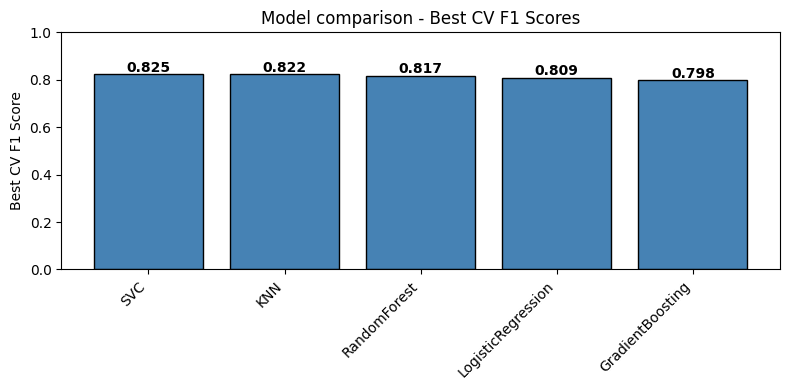

Model: SVC
  Best CV F1: 0.825
  Best params: {'C': np.float64(0.5645041271999772), 'gamma': 'scale', 'kernel': 'sigmoid'}
---
Model: KNN
  Best CV F1: 0.822
  Best params: {'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
---
Model: RandomForest
  Best CV F1: 0.817
  Best params: {'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 107}
---
Model: LogisticRegression
  Best CV F1: 0.809
  Best params: {'C': np.float64(0.5908361216819946), 'penalty': 'l2', 'solver': 'lbfgs'}
---
Model: GradientBoosting
  Best CV F1: 0.798
  Best params: {'learning_rate': np.float64(0.09355682060677284), 'max_depth': 2, 'n_estimators': 181, 'subsample': np.float64(0.9768807022739411)}
---


In [13]:
# Summarize results
res_df = pd.DataFrame(results).sort_values(by='best_score', ascending=False)

# Print summary table
print(res_df[['model', 'best_score']])

# Plot best CV F1 scores (skip models with no score)
valid = res_df.dropna(subset=['best_score']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(valid['model'], valid['best_score'], color='steelblue', edgecolor='black')
ax.set_ylim(0, 1)
ax.set_ylabel('Best CV F1 Score')
ax.set_title('Model comparison - Best CV F1 Scores')
for i, v in enumerate(valid['best_score']):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print best params / errors
for _, row in res_df.iterrows():
    print('Model:', row['model'])
    if row['best_score'] is not None:
        print(f"  Best CV F1: {row['best_score']:.3f}")
        print('  Best params:', row['best_params'])
    else:
        print('  Error:', row.get('error'))
    print('---')